In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
from tqdm import tqdm
import os
import io

In [2]:
import community as community_louvain
from scipy.io import mmread
from scipy.sparse import issparse

In [14]:
data_path = 'socfb-Auburn71/socfb-Auburn71.mtx'
sparse_matrix = mmread(data_path)

In [15]:
G = nx.from_scipy_sparse_array(sparse_matrix)

In [16]:
G = G.to_undirected()

In [17]:
G.remove_edges_from(nx.selfloop_edges(G))

In [18]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Average Degree
degrees = [d for n, d in G.degree()]
avg_degree = sum(degrees) / num_nodes

# Density
density = nx.density(G)

# Average Clustering Coefficient
avg_clustering = nx.average_clustering(G)

In [20]:
if nx.is_connected(G):
    print(f"Graph is connected.")
    G_cc = G
else:
    # Get the largest connected component
    G_cc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    print(f"Graph is not connected. Largest component has {len(G_cc)} nodes.")

Graph is connected.


In [21]:
print(f"Nodes: {num_nodes}")
print(f"Edges: {num_edges}")
print(f"Average Degree: {avg_degree:.2f}")
print(f"Network Density: {density:.5f}")
print(f"Avg Clustering Coeff: {avg_clustering:.4f}")

Nodes: 18448
Edges: 973918
Average Degree: 105.59
Network Density: 0.00572
Avg Clustering Coeff: 0.2228


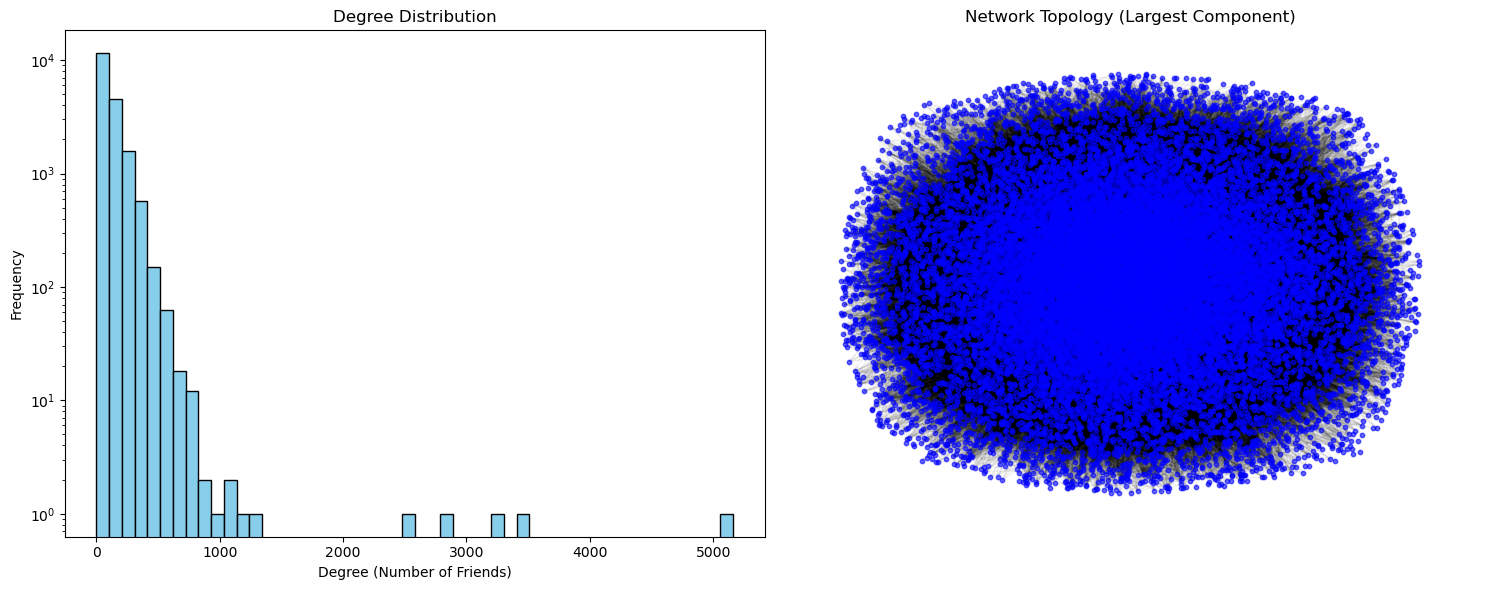

In [22]:
plt.figure(figsize=(15, 6))

# Degree Distribution Histogram
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree (Number of Friends)")
plt.ylabel("Frequency")
plt.yscale('log')

# Network Visualization (Spring Layout)
plt.subplot(1, 2, 2)
pos = nx.spring_layout(G_cc, seed=42, k=0.15, iterations=20)
nx.draw_networkx_nodes(G_cc, pos, node_size=10, node_color="blue", alpha=0.6)
nx.draw_networkx_edges(G_cc, pos, alpha=0.05)
plt.title(f"Network Topology (Largest Component)")
plt.axis('off')

plt.tight_layout()
plt.show()

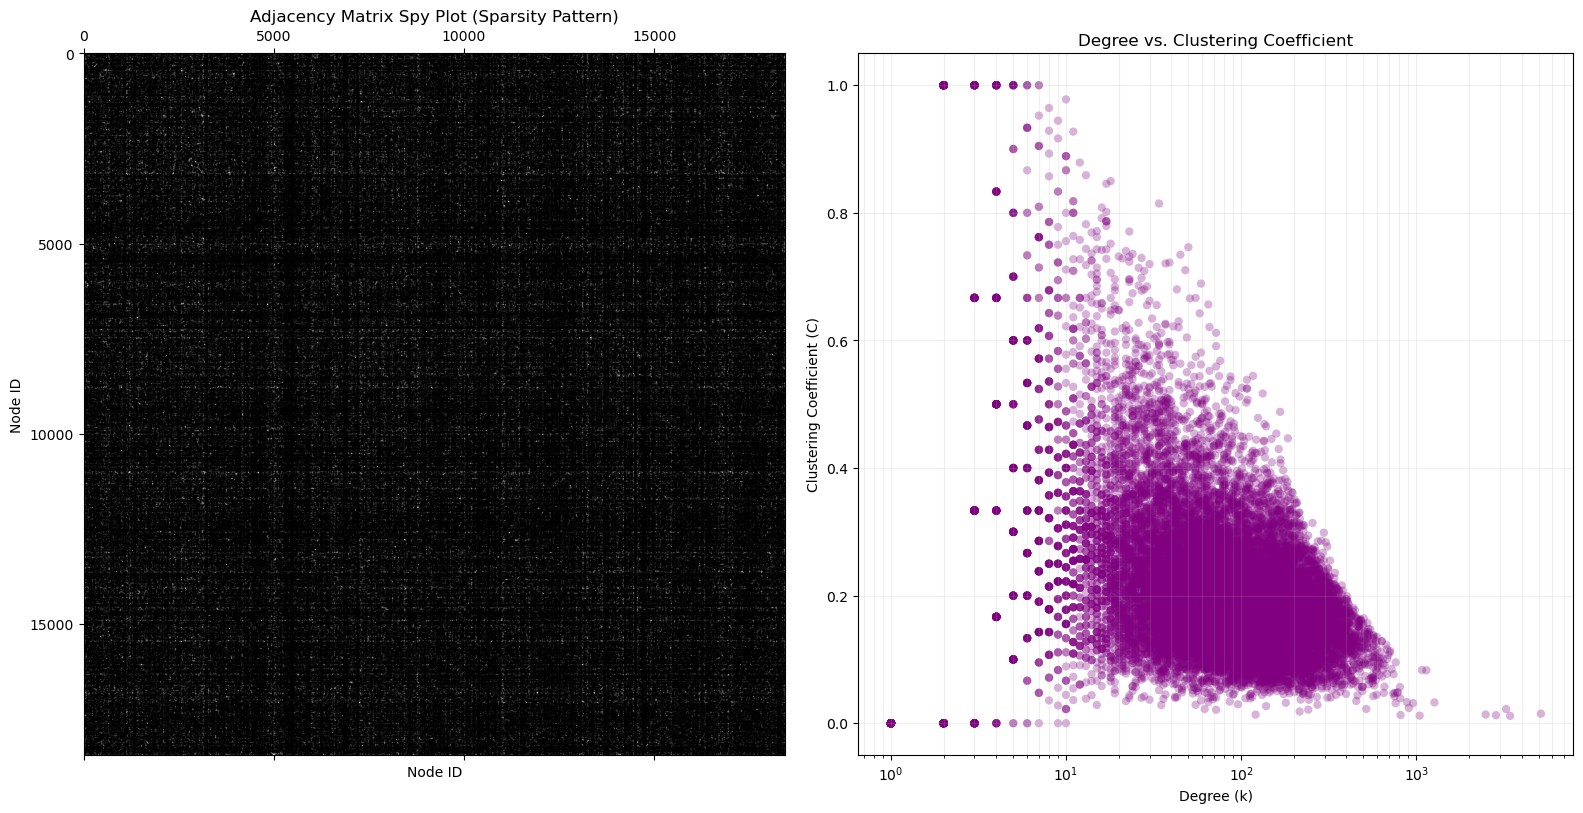

In [23]:
plt.figure(figsize=(16, 8))

# Adjacency Matrix Spy Plot
plt.subplot(1, 2, 1)

A = nx.to_scipy_sparse_array(G) 
plt.spy(A, markersize=0.1, color='black')
plt.title("Adjacency Matrix Spy Plot (Sparsity Pattern)")
plt.xlabel("Node ID")
plt.ylabel("Node ID")

# Degree vs. Clustering Coefficient
deg = dict(G.degree())
clus = nx.clustering(G)

degrees = list(deg.values())
clustering = list(clus.values())

plt.subplot(1, 2, 2)
plt.scatter(degrees, clustering, alpha=0.3, c='purple', edgecolors='none')
plt.title("Degree vs. Clustering Coefficient")
plt.xlabel("Degree (k)")
plt.ylabel("Clustering Coefficient (C)")
plt.xscale('log') # Log scale helps visualize the spread better
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

In [30]:
# 1. Create the K-Core Subgraph
# We remove anyone who doesn't have at least 25 connections within the core group.
# This usually reduces the graph size by 60-80% but keeps the main shape.
k = 80  
G_core = nx.k_core(G, k=k)

print(f"Original nodes: {len(G.nodes())}")
print(f"K-Core nodes (k={k}): {len(G_core.nodes())}")


Original nodes: 18448
K-Core nodes (k=80): 3901


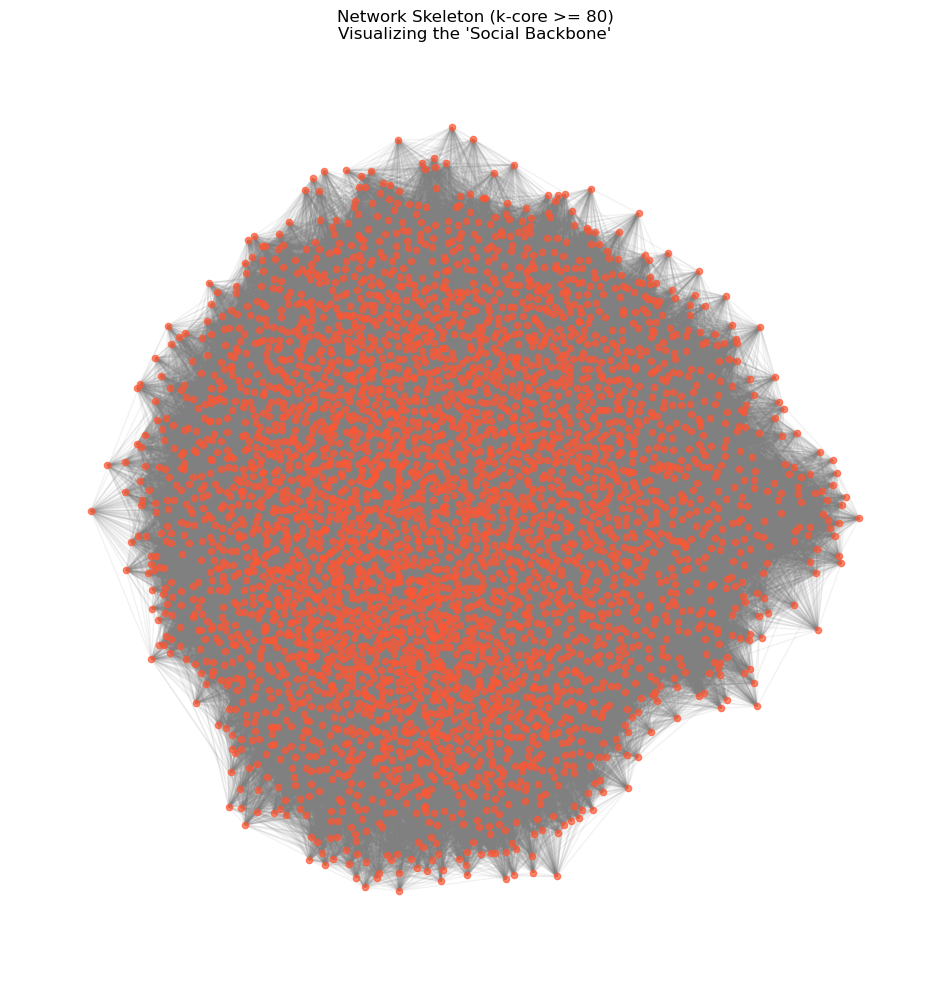

In [31]:
# 2. Plot the Skeleton
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_core, seed=42, k=0.2)  # k=0.2 pushes nodes apart

# Draw nodes (smaller size)
nx.draw_networkx_nodes(G_core, pos, node_size=20, node_color='#FF5733', alpha=0.7)

# Draw edges (very thin and transparent)
nx.draw_networkx_edges(G_core, pos, alpha=0.1, edge_color='gray')

plt.title(f"Network Skeleton (k-core >= {k})\nVisualizing the 'Social Backbone'")
plt.axis('off')
plt.show()

In [ ]:
data_path = 'socfb-Auburn71/socfb-Auburn71.mtx'
max_plot_node = 800
k_for_approx_betweenness = 500  # sample nodes if graph large for betweenness

In [5]:
if issparse(sparse_matrix):
    sparse_matrix = sparse_matrix.tocsr()
else:
    sparse_matrix = np.asarray(sparse_matrix)

In [6]:
# Determining if the matrix is symmetric (undirected) or not
try:
    if issparse(sparse_matrix):
        symmetric = (sparse_matrix != sparse_matrix.T).nnz == 0
    else:
        symmetric = np.array_equal(sparse_matrix, sparse_matrix.T)
except Exception:
    symmetric = False

In [7]:
# Detect if weighted 
if issparse(sparse_matrix):
    values = sparse_matrix.data
    weighted = not np.all(np.isin(values, [0,1]))
else:
    weighted = not np.all(np.isin(sparse_matrix, [0,1]))

In [8]:
G = nx.from_scipy_sparse_array(sparse_matrix)

In [9]:
print(f"Nodes (N): {G.number_of_nodes()}, Edges (M): {G.number_of_edges()}, symmetric (undirected): {symmetric}, weighted: {weighted}, directed: {G.is_directed()}")

Nodes (N): 18448, Edges (M): 973918, symmetric (undirected): True, weighted: False, directed: False


In [14]:
N = G.number_of_nodes()
M = G.number_of_edges()
density = nx.density(G)
degrees = np.array([d for n,d in G.degree(weight='weight')]) if weighted else np.array([d for n,d in G.degree()])
avg_degree = degrees.mean()

In [15]:
if (not G.is_directed() and nx.is_connected(G)) or (G.is_directed() and nx.is_weakly_connected(G)):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G.to_undirected() if G.is_directed() else G)
else:
    if G.is_directed():
        # use largest weakly connected component
        comps = list(nx.weakly_connected_components(G))
    else:
        comps = list(nx.connected_components(G))
    lcc = max(comps, key=len)
    G_lcc = G.subgraph(lcc).copy()
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    diameter = nx.diameter(G_lcc.to_undirected() if G_lcc.is_directed() else G_lcc)

avg_clustering = nx.average_clustering(G.to_undirected() if G.is_directed() else G)

In [16]:
print("\n=== Foundational Measures ===")
print(f"N (order): {N}")
print(f"M (size): {M}")
print(f"Density: {density:.6f}")
print(f"Average degree: {avg_degree:.4f}")
print(f"Average path length (LCC): {avg_path_length:.4f}")
print(f"Diameter (LCC): {diameter}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")


=== Foundational Measures ===
N (order): 18448
M (size): 973918
Density: 0.005724
Average degree: 105.5852
Average path length (LCC): 2.6755
Diameter (LCC): 7
Average clustering coefficient: 0.2228


In [17]:
pd.DataFrame({
    "measure":["N","M","density","avg_degree","avg_path_length","diameter","avg_clustering"],
    "value":[N,M,density,avg_degree,avg_path_length,diameter,avg_clustering]
}).to_csv("foundational_measures_mtx.csv", index=False)

In [21]:
max_plot_nodes = 800

def visualize_graph(G, fname="network_overview_mtx.png", title="Network overview"):
    if G.number_of_nodes() > max_plot_nodes:
        # choose largest connected/weakly-connected component
        if G.is_directed():
            cc = max(nx.weakly_connected_components(G), key=len)
        else:
            cc = max(nx.connected_components(G), key=len)
        sub = G.subgraph(cc).copy()
        if sub.number_of_nodes() > max_plot_nodes:
            deg_sorted = sorted(sub.degree(weight='weight' if weighted else None), key=lambda x: x[1], reverse=True)
            top_nodes = [n for n,_ in deg_sorted[:max_plot_nodes]]
            H = sub.subgraph(top_nodes).copy()
        else:
            H = sub
        subtitle = f"Largest CC/sample (n={H.number_of_nodes()})"
    else:
        H = G
        subtitle = f"Full graph (n={H.number_of_nodes()})"
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(H, seed=42, k=0.1, iterations=150)
    degs = dict(H.degree(weight='weight' if weighted else None))
    node_sizes = [max(20, degs[n]*6) for n in H.nodes()]
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(H, pos, alpha=0.2)
    topk = sorted(degs.items(), key=lambda x: x[1], reverse=True)[:8]
    labels = {n: str(n) for n,_ in topk}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
    plt.title(f"{title}\n{subtitle}")
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig(fname, dpi=200)
    plt.show()

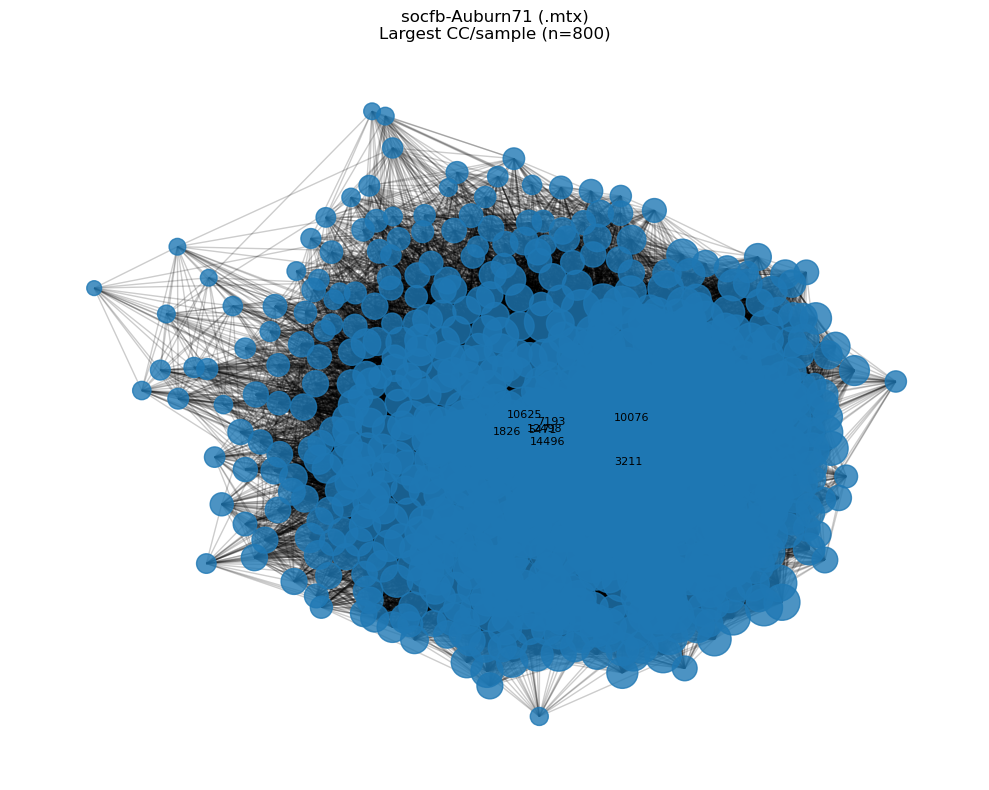

In [22]:
visualize_graph(G, fname="network_overview_mtx.png", title="socfb-Auburn71 (.mtx)")


In [23]:
print("\n=== Centralities ===")
# Degree centrality
deg_c = nx.degree_centrality(G)  # normalized by n-1

# Betweenness centrality (approx for large graphs)
if N > 5000:
    bet_c = nx.betweenness_centrality(G, k=k_for_approx_betweenness, seed=42, weight='weight' if weighted else None)
else:
    bet_c = nx.betweenness_centrality(G, weight='weight' if weighted else None)

# Eigenvector centrality (use numpy method for speed; for directed fallback to pagerank)
try:
    if G.is_directed():
        # eigenvector for directed: use numpy on adjacency of directed graph (may fail if not strongly connected)
        eig_c = nx.eigenvector_centrality_numpy(G)
    else:
        eig_c = nx.eigenvector_centrality_numpy(G)
except Exception:
    print("Eigenvector failed — falling back to PageRank as proxy.")
    eig_c = nx.pagerank(G, weight='weight' if weighted else None)

def topk(d, k=15):
    return pd.DataFrame(sorted(d.items(), key=lambda x: x[1], reverse=True)[:k], columns=["node","score"])

top_deg = topk(deg_c, 15)
top_bet = topk(bet_c, 15)
top_eig = topk(eig_c, 15)

print("\nTop 15 by Degree centrality:")
print(top_deg.to_string(index=False))
print("\nTop 15 by Betweenness centrality:")
print(top_bet.to_string(index=False))
print("\nTop 15 by Eigenvector/PageRank centrality:")
print(top_eig.to_string(index=False))


=== Centralities ===

Top 15 by Degree centrality:
 node    score
 5471 0.279720
10625 0.186426
14496 0.177102
12498 0.154876
 7193 0.135252
 1826 0.068954
10076 0.062070
 3211 0.058492
 2454 0.056757
 6394 0.052095
18336 0.049222
14710 0.047975
15170 0.044181
 4206 0.043964
16265 0.043801

Top 15 by Betweenness centrality:
 node    score
 5471 0.096656
10625 0.059351
12498 0.043387
14496 0.036652
 7193 0.029821
15170 0.005549
 2454 0.005194
18336 0.004435
 1826 0.004377
 6394 0.004125
 7703 0.003637
10076 0.003497
 3211 0.003028
15651 0.002578
14236 0.002445

Top 15 by Eigenvector/PageRank centrality:
 node    score
 5471 0.162446
14496 0.127699
10625 0.090570
12498 0.080786
 7193 0.074415
10076 0.073145
 3211 0.069757
 1826 0.054413
16368 0.050703
 5684 0.048980
18302 0.048016
16230 0.047132
 8966 0.046769
12834 0.046599
 4689 0.045163


In [24]:
central_df = pd.DataFrame({"node": list(G.nodes())})
central_df["degree_c"] = central_df["node"].map(deg_c)
central_df["betweenness_c"] = central_df["node"].map(bet_c)
central_df["eig_c"] = central_df["node"].map(eig_c)
central_df.to_csv("centralities_mtx.csv", index=False)

In [26]:
# -----------------------------
# Communities & Assortativity (C)
# -----------------------------
print("\n=== Communities (Louvain) & Assortativity ===")
# Louvain requires an undirected graph; use to_undirected() maintaining edge weights
G_for_comm = G.to_undirected() if G.is_directed() else G
if weighted:
    partition = community_louvain.best_partition(G, weight='weight')
else:
    partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G_for_comm, weight='weight' if weighted else None)
print(f"Modularity (Louvain): {modularity:.4f}")

comm_counts = Counter(partition.values())
print("Top communities by size:", sorted(comm_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Assortativity (degree pearson)
assort = nx.degree_pearson_correlation_coefficient(G_for_comm)
print(f"Degree assortativity coefficient: {assort:.4f}")

# Save community assignments
pd.DataFrame(list(partition.items()), columns=["node","community"]).to_csv("communities_mtx.csv", index=False)



=== Communities (Louvain) & Assortativity ===
Modularity (Louvain): 0.3774
Top communities by size: [(9, 4298), (10, 2349), (3, 2218), (1, 1997), (7, 1405), (6, 1204), (0, 1004), (5, 802), (2, 720), (8, 641)]
Degree assortativity coefficient: 0.0010


In [27]:
# Visualize communities
def visualize_communities(G, partition, fname="communities_mtx.png"):
    # sample if large as before
    if G.number_of_nodes() > max_plot_nodes:
        cc = max(nx.connected_components(G), key=len)
        sub = G.subgraph(cc).copy()
        if sub.number_of_nodes() > max_plot_nodes:
            deg_sorted = sorted(sub.degree(weight='weight' if weighted else None), key=lambda x:x[1], reverse=True)
            top_nodes = [n for n,_ in deg_sorted[:max_plot_nodes]]
            H = sub.subgraph(top_nodes).copy()
        else:
            H = sub
    else:
        H = G
    comms = [partition.get(n, -1) for n in H.nodes()]
    unique_comms = sorted(set(comms))
    cmap = plt.get_cmap("tab20")
    color_map = {cid: cmap(i % 20) for i,cid in enumerate(unique_comms)}
    colors = [color_map[c] for c in comms]
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(H, seed=42, k=0.1, iterations=150)
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=30)
    nx.draw_networkx_edges(H, pos, alpha=0.2)
    plt.title("Community structure (Louvain) — sampled view")
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig(fname, dpi=200)
    plt.show()

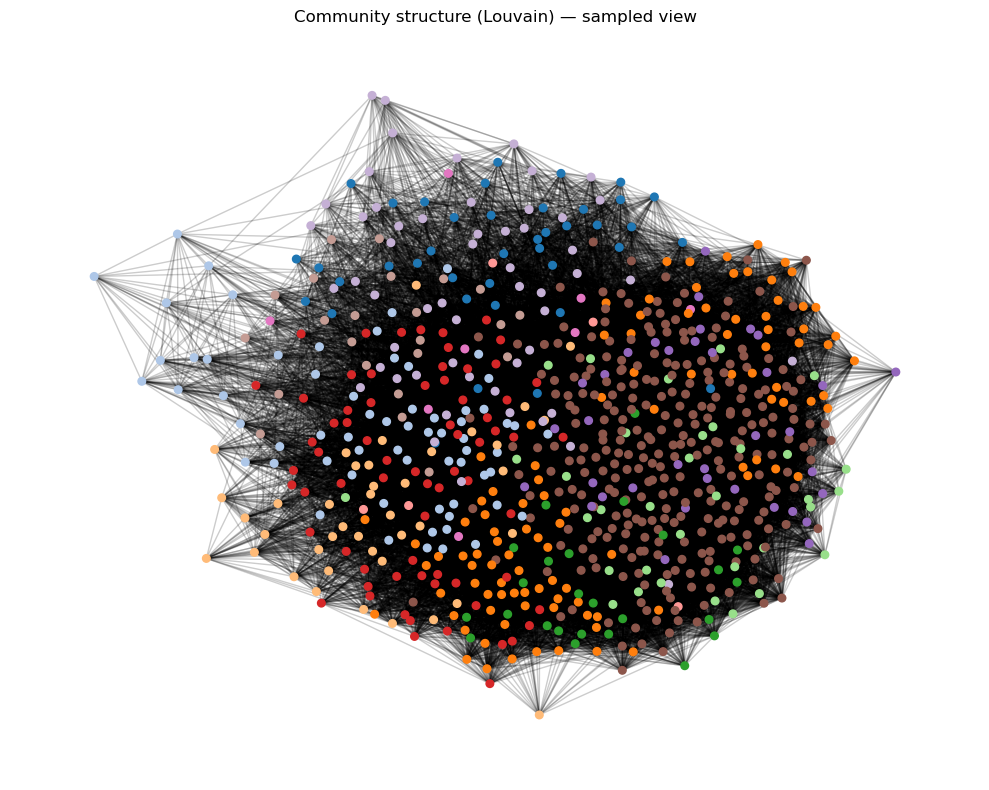

In [28]:
visualize_communities(G_for_comm, partition, fname="communities_mtx.png")


In [29]:
print("\n=== SIR simulation (process focus) ===")
def run_sir(G, beta=0.03, gamma=0.01, initial_infected=None, max_steps=500):
    status = {n:0 for n in G.nodes()}  # 0 S, 1 I, 2 R
    if isinstance(initial_infected, (list, tuple, set)):
        seeds = list(initial_infected)
    else:
        seeds = [initial_infected] if initial_infected is not None else [random.choice(list(G.nodes()))]
    for s in seeds: status[s] = 1
    infected = set(seeds)
    trajectory=[]
    for t in range(max_steps):
        new_inf=set(); new_rec=set()
        for u in list(infected):
            for v in G.neighbors(u):
                if status[v]==0:
                    if random.random() < beta:
                        new_inf.add(v)
            if random.random() < gamma:
                new_rec.add(u)
        for v in new_inf: status[v]=1
        for u in new_rec: status[u]=2
        infected |= new_inf
        infected -= new_rec
        s_counts = Counter(status.values())
        trajectory.append((t, s_counts.get(0,0), s_counts.get(1,0), s_counts.get(2,0)))
        if len(infected)==0:
            break
    return trajectory, status


=== SIR simulation (process focus) ===


In [30]:
def pick_seeds(metric_dict, k=3):
    sorted_nodes = sorted(metric_dict.items(), key=lambda x:x[1], reverse=True)
    return [n for n,_ in sorted_nodes[:k]], [n for n,_ in sorted_nodes[-k:]]

k_seeds = 3
top_seeds, low_seeds = pick_seeds(deg_c, k=k_seeds)
rnd_seeds = random.sample(list(G.nodes()), k_seeds)

print("Top-degree seeds:", top_seeds)
print("Low-degree seeds:", low_seeds)
print("Random seeds:", rnd_seeds)

Top-degree seeds: [5471, 10625, 14496]
Low-degree seeds: [17851, 18231, 18318]
Random seeds: [11580, 6397, 17930]


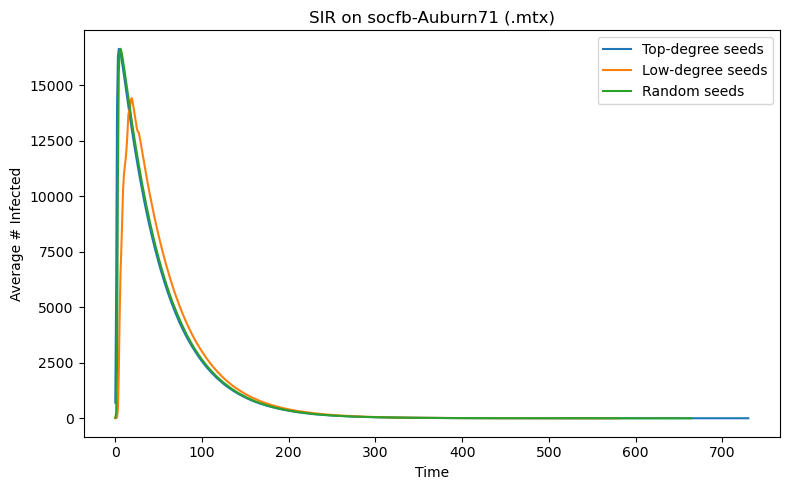

In [31]:
def avg_sir(G, seeds, runs=40, beta=0.06, gamma=0.02):
    all_traj=[]; finals=[]
    for r in range(runs):
        traj, status = run_sir(G, beta=beta, gamma=gamma, initial_infected=seeds, max_steps=1000)
        all_traj.append(traj)
        finals.append(sum(1 for s in status.values() if s==2))
    max_t = max((traj[-1][0] if traj else 0) for traj in all_traj)
    times = list(range(max_t+1))
    avg_I=[]
    for t in times:
        vals=[]
        for traj in all_traj:
            found = next((x for x in traj if x[0]==t), None)
            vals.append(found[2] if found else 0)
        avg_I.append(np.mean(vals))
    return times, avg_I, finals

times_top, avg_I_top, finals_top = avg_sir(G, top_seeds, runs=40)
times_low, avg_I_low, finals_low = avg_sir(G, low_seeds, runs=40)
times_rnd, avg_I_rnd, finals_rnd = avg_sir(G, rnd_seeds, runs=40)

plt.figure(figsize=(8,5))
plt.plot(times_top, avg_I_top, label="Top-degree seeds")
plt.plot(times_low, avg_I_low, label="Low-degree seeds")
plt.plot(times_rnd, avg_I_rnd, label="Random seeds")
plt.xlabel("Time")
plt.ylabel("Average # Infected")
plt.title("SIR on socfb-Auburn71 (.mtx)")
plt.legend()
plt.tight_layout()
# plt.savefig("sir_mtx.png", dpi=200)
plt.show()

In [32]:

print("\nSIR final recovered means:")
print("Top seeds:", np.mean(finals_top), "Low seeds:", np.mean(finals_low), "Random seeds:", np.mean(finals_rnd))



SIR final recovered means:
Top seeds: 18374.05 Low seeds: 18372.375 Random seeds: 18372.375


In [33]:
top_deg.to_csv("top_degree_mtx.csv", index=False)
top_bet.to_csv("top_betweenness_mtx.csv", index=False)
top_eig.to_csv("top_eigenvector_mtx.csv", index=False)
pd.DataFrame(list(partition.items()), columns=["node","community"]).to_csv("communities_mtx.csv", index=False)

with open("report_summary_mtx.txt","w") as f:
    f.write("Summary for socfb-Auburn71 (.mtx)\n")
    f.write("===============================\n")
    f.write(f"N: {N}\nM: {M}\nDensity: {density:.6f}\nAvg degree: {avg_degree:.4f}\n")
    f.write(f"Avg path length (LCC): {avg_path_length:.4f}\nDiameter: {diameter}\nAvg clustering: {avg_clustering:.4f}\n")
    f.write(f"Modularity (Louvain): {modularity:.4f}\nAssortativity: {assort:.4f}\n")
    f.write("\nTop-degree nodes:\n"); f.write(top_deg.to_string(index=False))
    f.write("\n\nTop-betweenness nodes:\n"); f.write(top_bet.to_string(index=False))

print("\nSaved outputs: foundational measures, centralities, community assignments, visualizations, SIR plot, report_summary_mtx.txt")


Saved outputs: foundational measures, centralities, community assignments, visualizations, SIR plot, report_summary_mtx.txt
